In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")

%matplotlib inline

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/d.parpulov/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
transactions = pd.read_csv('../transactions.csv')
customers_gender = pd.read_csv('../customers_gender_train.csv')
tr_mcc_codes = pd.read_csv('../tr_mcc_codes.csv', sep=';')
tr_types = pd.read_csv('../tr_types.csv', sep=';')

In [3]:
transactions1 = pd.merge(transactions, customers_gender, on='customer_id', how='outer')

### gender tr_types

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


,tr_type,amount,tr_description
0,1010,1589734,Покупка. POS ТУ СБ РФ
1,2010,1040713,Выдача наличных в АТМ Сбербанк России
2,1030,970994,Оплата услуги. Банкоматы СБ РФ
3,1110,928154,Покупка. POS ТУ Россия
4,7070,691896,Перевод на карту (с карты) через Мобильный бан...
5,2370,376521,Списание с карты на карту по операции <перевод...
6,7010,258088,Взнос наличных через АТМ (в своем тер.банке)
7,7030,155200,Перевод на карту (с карты) через АТМ (в предел...
8,1100,117870,Покупка. ТУ Россия
9,7071,96146,Перевод на карту (с карты) через Мобильный бан...


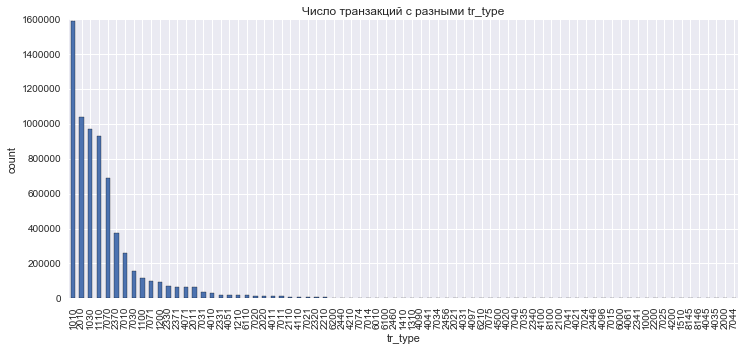

In [4]:
tmp = transactions1.groupby('tr_type').amount.count()
tmp.sort(ascending=False)
#figsize(12, 5)
tmp.plot(kind='bar', figsize=(12,5))
plt.xlabel('tr_type')
plt.ylabel('count')
plt.title(u'Число транзакций с разными tr_type')
pd.merge(tmp[:15].reset_index(), tr_types)

In [5]:
trtype = pd.merge(pd.crosstab(transactions1.tr_type, transactions1.gender).reset_index(), tr_types)
trtype['k_type'] = (trtype[1.0] - trtype[0.0])/(trtype[0.0] + trtype[1.0])
trtype = trtype[(trtype[0.0] + trtype[1.0]) > 50] # достаточно статистики
trtype.head()
trtype.sort('k_type',  ascending=False, inplace=True)
trtype.columns = [u'tr_type', u'ж', u'м', u'tr_type_description', u'k_type']
trtype.set_index(trtype.tr_type, inplace=True)
del trtype['tr_type']
trtype.head()

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,ж,м,tr_type_description,k_type
tr_type,,,,
6210,39,377,Возврат покупки.POS Зарубеж. ТУ,0.812500
1310,130,749,н/д,0.704209
7075,58,332,Перевод с карты на карту в овердрафте через Мо...,0.702564
1410,240,854,н/д,0.561243
7035,52,119,Перевод на карту/ с карты через АТМ (со взиман...,0.391813


In [6]:
trtype.tail()

,ж,м,tr_type_description,k_type
tr_type,,,,
2320,2539,1444,Безналичный перевод денежных средств через POS,-0.274918
4100,77,41,Плата за получение наличных. Россия,-0.305085
6200,2183,1150,Возврат покупки. Зарубеж. ТУ,-0.309931
7034,518,138,Перевод на карту/ с карты через АТМ (без взима...,-0.579268
8100,107,15,Списание после проведения претензионной работы,-0.754098


## Gender mcc_codes

In [7]:
mccode = pd.merge(pd.crosstab(transactions1.mcc_code, transactions1.gender).reset_index(), tr_mcc_codes)
mccode['k_mcc'] = (mccode[1.0] - mccode[0.0])/(mccode[0.0] + mccode[1.0])

mccode.sort('k_mcc',  ascending=False, inplace=True)
mccode.columns = [u'mcc_code', u'ж', u'м', u'mcc_description', u'k_mcc']
mccode.set_index(mccode.mcc_code, inplace=True)
del mccode['mcc_code']
mccode.head(5)

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,ж,м,mcc_description,k_mcc
mcc_code,,,,
5967,5,289,Прямой маркетинг — входящий телемаркетинг,0.965986
1731,8,65,Подрядчики по электричеству,0.780822
7995,2431,15650,Транзакции по азартным играм,0.731099
7994,1164,7404,Галереи/учреждения видеоигр,0.728291
6211,133,776,Ценные бумаги: брокеры/дилеры,0.707371


## Explore traty by segment

In [8]:
mean_rashod_amount = transactions1[transactions1.amount<0].groupby("mcc_code").amount.mean().reset_index() #только траты
mean_rashod_amount.columns = ["mcc_code", "mean_mcc_amount_rashod"]
mean_rashod_amount.head()  # средний расход всех кастомеров в сегменте

,mcc_code,mean_mcc_amount_rashod
0,742,-24517.757018
1,1711,-110246.181696
2,1731,-22525.922099
3,1799,-92968.086034
4,2741,-27471.208269


In [9]:
customer_rashod_mcc = transactions1[transactions1.amount<0].groupby(["customer_id", "mcc_code"]).amount.mean().reset_index()
# средний расход каждого юзера в данном мсс коде
customer_rashod_mcc.columns = ["customer_id", "mcc_code", "mean_amount_rashod_mcc"]
customer_rashod_mcc.head()

,customer_id,mcc_code,mean_amount_rashod_mcc
0,6815,4814,-2770.465889
1,6815,5311,-8070.017241
2,6815,5411,-8139.523793
3,6815,5921,-12464.835000
4,6815,6011,-45880.852571


### Посмотрим, отличаются ли траты по сегментам, в зависимости от пола

In [10]:
tr = pd.merge(transactions1[["customer_id", "mcc_code", "gender"]], customer_rashod_mcc)

mean_gender_mcc_traty = tr.groupby(["mcc_code", "gender"]).mean_amount_rashod_mcc.mean().unstack().reset_index()
mean_gender_mcc_traty.columns = ["mcc_code", "f", "m"]
mean_gender_mcc_traty['k_mcc_traty'] = (-mean_gender_mcc_traty["m"] - -mean_gender_mcc_traty["f"])/\
                                        (-mean_gender_mcc_traty["f"] + -mean_gender_mcc_traty["m"])

посмотрим на топ

In [11]:
pd.merge(mean_gender_mcc_traty.sort_values("k_mcc_traty", ascending=False).head(10), tr_mcc_codes)
# ну вообще-то показательно!!!

,mcc_code,f,m,k_mcc_traty,mcc_description
0,5968,-23270.366850,-1.308225e+06,0.965046,Прямой маркетинг — торговые точки подписки
1,5940,-47158.840909,-2.086255e+06,0.955790,Веломагазины — продажа и обслуживание
2,8398,-7833.136415,-2.970880e+05,0.948622,Организации благотворительные и общественные с...
3,6513,-54282.680833,-9.880548e+05,0.895844,Агенты и менеджеры по аренде недвижимости
4,8699,-44334.205238,-4.832830e+05,0.831946,"Организации, членства, нигде ранее не классифи..."
5,8220,-121961.378750,-7.272393e+05,0.712762,"Колледжи, университеты, профессиональные школы..."
6,7531,-25182.954444,-1.340364e+05,0.683670,Станции технического обслуживания для автомоби...
7,5094,-43033.282397,-1.893381e+05,0.629616,"Драгоценные камни и металлы, часы и ювелирные ..."
8,5072,-21131.697407,-7.281719e+04,0.550145,Оборудование и сопутствующие материалы для тех...
9,8299,-82227.201484,-2.780755e+05,0.543566,Образовательные услуги


## Explore income by segment

In [12]:
mean_income_amount = transactions1[transactions1.amount>0].groupby("mcc_code").amount.mean().reset_index() #только траты
mean_income_amount.columns = ["mcc_code", "mean_mcc_amount_income"]
mean_income_amount.head()  # средний доход всех кастомеров в сегменте

,mcc_code,mean_mcc_amount_income
0,1711,49410.150000
1,2741,34076.830000
2,3000,319591.321010
3,3351,173277.535714
4,3501,302379.320000


In [13]:
customer_income_mcc = transactions1[transactions1.amount>0].groupby(["customer_id", "mcc_code"]).amount.mean().reset_index()
# средний доход каждого юзера в данном мсс коде
customer_income_mcc.columns = ["customer_id", "mcc_code", "mean_amount_income_mcc"]
customer_income_mcc.head()

,customer_id,mcc_code,mean_amount_income_mcc
0,6815,6010,2.470507e+06
1,6815,6011,4.720915e+04
2,22899,6010,5.860164e+04
3,22899,6011,1.044519e+05
4,27914,6010,7.860705e+04


### Посмотрим, отличаются ли доходы по сегментам, в зависимости от пола

In [14]:
tr = pd.merge(transactions1[["customer_id", "mcc_code", "gender"]], customer_income_mcc)

mean_gender_mcc_income = tr.groupby(["mcc_code", "gender"]).mean_amount_income_mcc.mean().unstack().reset_index()
mean_gender_mcc_income.columns = ["mcc_code", "f", "m"]
mean_gender_mcc_income['k_mcc_income'] = (mean_gender_mcc_income["m"] - mean_gender_mcc_income["f"])/\
                                        (mean_gender_mcc_income["f"] + mean_gender_mcc_income["m"])

посмотрим на топ

In [15]:
pd.merge(mean_gender_mcc_income.sort_values("k_mcc_income", ascending=False).head(10), tr_mcc_codes)
# ну вообще-то показательно!!!

,mcc_code,f,m,k_mcc_income,mcc_description
0,5094,8556.424286,942543.996667,0.982007,"Драгоценные камни и металлы, часы и ювелирные ..."
1,5983,2790.773657,129848.894942,0.957919,"Горючее топливо — уголь, нефть, разжиженный бе..."
2,5965,33576.891250,445033.150000,0.859690,Прямой маркетинг — комбинированный каталог и т...
3,5309,73185.706158,847993.671429,0.841104,Беспошлинные магазины Duty Free
4,5812,6121.534187,66472.781425,0.831349,"Места общественного питания, рестораны"
5,5713,36209.472727,310847.187143,0.791334,Покрытия для пола
6,8999,9847.081427,83694.910638,0.789462,"Профессиональные услуги, нигде ранее не класси..."
7,4829,22144.817414,140151.826344,0.727107,Денежные переводы
8,7993,12330.080000,71846.850000,0.707044,Принадлежности для видеоигр
9,5912,7177.262854,39679.536831,0.693651,Аптеки


## Explore traty by transactions type

In [16]:
mean_rashod_amount_trtype = transactions1[transactions1.amount<0].groupby("tr_type").amount.mean().reset_index() #только траты
mean_rashod_amount_trtype.columns = ["tr_type", "mean_trtype_amount_rashod"]
mean_rashod_amount_trtype.head()  # средний расход всех кастомеров по данному типу транзакции

,tr_type,mean_trtype_amount_rashod
0,1000,-316414.063023
1,1010,-17057.547630
2,1030,-4700.393461
3,1100,-39823.624382
4,1110,-26788.780933


In [17]:
customer_rashod_trtype = transactions1[transactions1.amount<0].groupby(["customer_id", "tr_type"]).amount.mean().reset_index()
# средний расход каждого юзера по данному типу транзакции
customer_rashod_trtype.columns = ["customer_id", "tr_type", "mean_amount_rashod_trtype"]
customer_rashod_trtype.head()

,customer_id,tr_type,mean_amount_rashod_trtype
0,6815,1010,-7627.253810
1,6815,1030,-2770.465889
2,6815,1110,-9703.427778
3,6815,2010,-45880.852571
4,22899,1010,-6237.096667


### Посмотрим, отличаются ли расходы по типам транзакций, в зависимости от пола

In [18]:
tr = pd.merge(transactions1[["customer_id", "tr_type", "gender"]], customer_rashod_trtype)

mean_gender_trtype_rashod = tr.groupby(["tr_type", "gender"]).mean_amount_rashod_trtype.mean().unstack().reset_index()
mean_gender_trtype_rashod.columns = ["tr_type", "f", "m"]
mean_gender_trtype_rashod['k_trtype_rashod'] = (-mean_gender_trtype_rashod["m"] - -mean_gender_trtype_rashod["f"])/\
                                                (-mean_gender_trtype_rashod["f"] + -mean_gender_trtype_rashod["m"])

In [19]:
mean_gender_trtype_rashod.sort("k_trtype_rashod").head()

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,tr_type,f,m,k_trtype_rashod
49,6110,-80403.786000,-20774.720000,-0.589345
0,1000,-220331.428571,-125480.652609,-0.274284
27,2446,-187459.104000,-120105.450455,-0.218990
42,4096,-2884.877000,-1868.191364,-0.213901
7,1310,-32037.820462,-22528.525581,-0.174270


In [20]:
# это топ
pd.merge(mean_gender_trtype_rashod.sort_values("k_trtype_rashod", ascending=False).head(10), tr_types)

,tr_type,f,m,k_trtype_rashod,tr_description
0,7071,-16282.890000,-4.043771e+05,0.922584,Перевод на карту (с карты) через Мобильный бан...
1,1510,-131911.436000,-7.222955e+05,0.691149,н/д
2,7030,-13860.889770,-6.041513e+04,0.626773,Перевод на карту (с карты) через АТМ (в предел...
3,2341,-668371.059500,-2.408681e+06,0.565577,Списание с карты по операции “перевода с карты...
4,4045,-884.330000,-3.183632e+03,0.565222,н/д
5,4021,-5392.530575,-1.738256e+04,0.526454,Плата за получение наличных через POS в Сберба...
6,2020,-354565.791564,-8.742304e+05,0.422905,Выдача наличных через POS Сбербанка
7,4061,-5066.605000,-1.135390e+04,0.382893,Плата за перевод на карту (с карты) через POS ...
8,2021,-745090.501418,-1.613496e+06,0.368189,Выдача наличных через POS Сбербанка (в других ТБ)
9,2330,-182027.296172,-3.660178e+05,0.335721,Списание с карты по операции “перевода с карты...


## Explore income by transactions type

In [21]:
mean_income_amount_trtype = transactions1[transactions1.amount>0].groupby("tr_type").amount.mean().reset_index() #только траты
mean_income_amount_trtype.columns = ["tr_type", "mean_trtype_amount_income"]
mean_income_amount_trtype.head()  # средний доход всех кастомеров по данному типу транзакции

,tr_type,mean_trtype_amount_income
0,1010,27324.343261
1,1030,12440.333636
2,1100,31408.831872
3,1110,55684.434547
4,1200,157983.736889


In [22]:
customer_income_trtype = transactions1[transactions1.amount>0].groupby(["customer_id", "tr_type"]).amount.mean().reset_index()
# средний расход каждого юзера по данному типу транзакции
customer_income_trtype.columns = ["customer_id", "tr_type", "mean_amount_income_trtype"]
customer_income_trtype.head()

,customer_id,tr_type,mean_amount_income_trtype
0,6815,7010,4.720915e+04
1,6815,7031,2.470507e+06
2,22899,7010,1.044519e+05
3,22899,7030,8.553196e+04
4,22899,7031,4.491832e+04


### Посмотрим, отличаются ли доход по типам транзакций, в зависимости от пола

In [23]:
tr = pd.merge(transactions1[["customer_id", "tr_type", "gender"]], customer_income_trtype)

mean_gender_trtype_income = tr.groupby(["tr_type", "gender"]).mean_amount_income_trtype.mean().unstack().reset_index()
mean_gender_trtype_income.columns = ["tr_type", "f", "m"]
mean_gender_trtype_income['k_trtype_income'] = (mean_gender_trtype_income["m"] - mean_gender_trtype_income["f"])/\
                                                (mean_gender_trtype_income["f"] + mean_gender_trtype_income["m"])

In [24]:
# это топ
pd.merge(mean_gender_trtype_income.sort_values("k_trtype_income", ascending=False).head(10), tr_types)

,tr_type,f,m,k_trtype_income,tr_description
0,2011,6737.750000,3.116688e+05,0.957678,Выдача наличных в АТМ Сбербанка (в других ТБ)
1,2370,9693.862608,2.537009e+05,0.926393,Списание с карты на карту по операции <перевод...
2,7024,195176.239355,2.482383e+06,0.854213,Взнос наличных через POS (в своем ТБ) по счету...
3,1030,3515.737512,3.595781e+04,0.821869,Оплата услуги. Банкоматы СБ РФ
4,8100,13404.724206,1.295790e+05,0.812500,Списание после проведения претензионной работы
5,7020,395597.331681,1.143527e+06,0.485945,Взнос наличных через POS
6,7034,158425.979691,4.548667e+05,0.483359,Перевод на карту/ с карты через АТМ (без взима...
7,7041,993595.946250,2.794761e+06,0.475448,Перевод на карту (с карты) через POS (из одног...
8,6200,14399.697517,4.025488e+04,0.473065,Возврат покупки. Зарубеж. ТУ


## All

In [25]:
print 'Male: ', len(pd.unique(transactions1[transactions1.gender == 1.0].customer_id))
print "Female", len(pd.unique(transactions1[transactions1.gender == 0.0].customer_id))
# всего человек - женщин чуть больше

Male:  5306
Female 6694


In [26]:
one = transactions1.groupby(["customer_id", "mcc_code", "tr_type"]).amount.mean().reset_index()

In [27]:
merged1 = pd.merge(pd.merge(pd.merge(one, trtype.reset_index()[["tr_type", "k_type"]]), \
         mccode.reset_index()[["mcc_code", "k_mcc"]]), mean_gender_mcc_traty[["mcc_code", "k_mcc_traty"]])

In [28]:
merged = pd.merge(pd.merge(pd.merge(merged1, mean_gender_mcc_income[["mcc_code", "k_mcc_income"]]), \
         mean_gender_trtype_rashod[["tr_type","k_trtype_rashod"]]), \
                  mean_gender_trtype_income[["tr_type","k_trtype_income"]])

In [29]:
merged = merged.fillna(0)

In [30]:
merged[merged.customer_id==6815]

,customer_id,mcc_code,tr_type,amount,k_type,k_mcc,k_mcc_traty,k_mcc_income,k_trtype_rashod,k_trtype_income
0,6815,4814,1030,-2.770466e+03,-0.160782,-0.157460,0.147842,0.349196,0.146184,0.821869
14281,6815,5311,1010,-8.070017e+03,-0.042922,-0.110934,0.109353,-0.109188,0.084700,0.366052
16410,6815,5411,1010,-5.580408e+03,-0.042922,-0.056353,0.049698,0.249510,0.084700,0.366052
28457,6815,5921,1010,-1.246483e+04,-0.042922,0.279057,0.057176,0.596813,0.084700,0.366052
165375,6815,5411,1110,-9.703428e+03,0.042832,-0.056353,0.049698,0.249510,0.092908,0.157318
328025,6815,6010,7031,2.470507e+06,0.001821,-0.154689,-0.010877,0.258174,0.000000,0.270451
397334,6815,6011,2010,-4.588085e+04,-0.033296,-0.022971,0.212007,0.217838,0.215751,0.252051
412058,6815,6011,7010,4.720915e+04,-0.064336,-0.022971,0.212007,0.217838,0.000000,0.268630


In [31]:
## from customer id --> sex, to triple(cestomer_id, mcc_code, tr_type) --> sex!!

In [32]:
gender_labels_data = transactions1[pd.notnull(transactions1.gender)][["customer_id", "mcc_code", "tr_type", "gender"]].drop_duplicates().reset_index().drop(["index"],axis=1)

In [33]:
dataset = pd.merge(merged,gender_labels_data, how="left").sort_values(by="customer_id").reset_index().drop(["index"],axis=1)

In [34]:
dataset.head()

,customer_id,mcc_code,tr_type,amount,k_type,k_mcc,k_mcc_traty,k_mcc_income,k_trtype_rashod,k_trtype_income,gender
0,6815,4814,1030,-2770.465889,-0.160782,-0.157460,0.147842,0.349196,0.146184,0.821869,0.0
1,6815,5411,1010,-5580.408182,-0.042922,-0.056353,0.049698,0.249510,0.084700,0.366052,0.0
2,6815,5921,1010,-12464.835000,-0.042922,0.279057,0.057176,0.596813,0.084700,0.366052,0.0
3,6815,5411,1110,-9703.427778,0.042832,-0.056353,0.049698,0.249510,0.092908,0.157318,0.0
4,6815,6011,7010,47209.150000,-0.064336,-0.022971,0.212007,0.217838,0.000000,0.268630,0.0


In [38]:
train_all = dataset[pd.notnull(dataset.gender)]
test = dataset[pd.isnull(dataset.gender)][dataset.columns[:-1]]

len(pd.unique(test.customer_id))  # ok

3000

In [39]:
len(pd.unique(train_all.customer_id))

12000

In [40]:
pd.unique(train_all.customer_id)  # на трейн и тест надо разбить по кастомерам

array([    6815,    22899,    27914, ..., 99988578, 99991245, 99999680])

In [41]:
train_customers_id = pd.unique(train_all.customer_id)[:9000]
print len(train_customers_id)
test_customers_id = pd.unique(train_all.customer_id)[9000:]
print len(test_customers_id)

9000
3000


In [42]:
train = pd.merge(train_all, pd.DataFrame(train_customers_id, columns=["customer_id"]))
val = pd.merge(train_all, pd.DataFrame(test_customers_id, columns=["customer_id"]))

In [43]:
X_train = train[train_all.columns[:-1]]
X_val = val[train_all.columns[:-1]]

Y_train = train.gender.apply(lambda x: int(x))
Y_val = val.gender.apply(lambda x: int(x))

In [44]:
def get_dummy_mcc(df):
    dummy_mcc = pd.get_dummies(df.loc[:,"mcc_code"])
    dummy_mcc.columns = map(lambda x: "mcc_" + str(x), pd.unique(df.mcc_code))
    return dummy_mcc

def get_dummy_type(df):
    dummy_type = pd.get_dummies(df.loc[:,"tr_type"])
    dummy_type.columns = map(lambda x: "type_" + str(x), pd.unique(df.tr_type))

In [45]:
try_train = pd.concat([X_train[X_train.columns[1:]]], axis=1).fillna(0)
try_val = pd.concat([X_val[X_val.columns[1:]]], axis=1).fillna(0)

try_test = pd.concat([test[test.columns[1:]]], axis=1).fillna(0)

In [46]:
try_train = pd.concat([get_dummy_mcc(X_train), get_dummy_type(X_train), X_train[X_train.columns[3:]]], axis=1)
try_val = pd.concat([get_dummy_mcc(X_val), get_dummy_type(X_val), X_val[X_val.columns[3:]]], axis=1)

try_test = pd.concat([get_dummy_mcc(test), get_dummy_type(test), test[test.columns[3:]]], axis=1)

In [44]:
%%time
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.7, min_samples_split=10, max_depth=7, \
                                 max_features="auto", verbose=1, warm_start=True, random_state=13)
clf.fit(try_train, Y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3728           0.0075            7.80m
         2           1.3664           0.0062            7.36m
         3           1.3615           0.0050            7.05m
         4           1.3568           0.0041            6.87m
         5           1.3529           0.0033            6.80m
         6           1.3493           0.0028            6.80m
         7           1.3470           0.0025            6.64m
         8           1.3448           0.0020            6.58m
         9           1.3423           0.0016            6.59m
        10           1.3411           0.0012            6.47m
        20           1.3320           0.0001            5.60m
        30           1.3285           0.0000            4.84m
        40           1.3260           0.0000            4.10m
        50           1.3234          -0.0000            3.38m
        60           1.3224           0.0000            2.68m
       

In [46]:
clf.feature_importances_

array([  3.58403195e-04,   3.01131123e-04,   1.40303080e-06,
         3.12356854e-03,   1.50202038e-03,   6.15996926e-05,
         2.67339152e-04,   1.16288312e-03,   1.92007526e-03,
         1.98114118e-04,   7.46693409e-04,   1.93129999e-03,
         4.62614814e-03,   0.00000000e+00,   9.76476316e-04,
         4.28962442e-04,   1.30246304e-03,   3.65289997e-04,
         1.91254073e-04,   3.23634388e-04,   0.00000000e+00,
         1.82263681e-06,   1.44832504e-04,   0.00000000e+00,
         5.97638865e-04,   0.00000000e+00,   2.00754749e-04,
         8.15165903e-04,   1.55873148e-04,   2.54603854e-03,
         8.73335110e-04,   4.25920775e-04,   4.86943179e-04,
         5.66383651e-04,   6.80290965e-04,   9.34584778e-04,
         4.64672652e-04,   1.35539017e-03,   1.27243030e-03,
         6.35069365e-05,   3.08271412e-03,   3.74856462e-04,
         2.93135385e-04,   2.01909078e-03,   4.39562356e-04,
         4.35496658e-04,   5.49450029e-04,   9.74747465e-04,
         3.06165342e-04,

In [411]:
predicted = clf.predict_proba(try_test)[:, 1]

In [412]:
predicted.min(), predicted.max()

(0.095791327128866496, 0.93651143485231614)

In [413]:
val_pred = pd.concat([test.reset_index().drop(["index"], axis=1), pd.Series(predicted, name="pred_gender")], axis=1)
val_pred = val_pred.groupby("customer_id").pred_gender.mean().reset_index()

In [414]:
val_pred.pred_gender.max(), val_pred.pred_gender.min(), 

(0.63503509378200085, 0.33334182744812657)

In [393]:
val_pred.pred_gender = val_pred.pred_gender.apply(lambda x: (x-val_pred.pred_gender.min())/(val_pred.pred_gender.max()-val_pred.pred_gender.min()))

In [415]:
val_pred.pred_gender.max(), val_pred.pred_gender.min(), 

(0.63503509378200085, 0.33334182744812657)

In [408]:
val_true = pd.concat([X_val, Y_val], axis=1)
val_true = val_true.groupby("customer_id").gender.mean().reset_index()

In [352]:
al = pd.merge(val_true, val_pred)
al.head()

,customer_id,gender,pred_gender
0,75248245,1,0.508710
1,75278479,0,0.495366
2,75281100,0,0.417223
3,75282650,0,0.382108
4,75328477,1,0.473742


In [409]:
print "LogLoss %s" % str(log_loss(val_true.gender, np.array(val_pred.pred_gender))) 
print "Auc score %s" % str(roc_auc_score(val_true.gender, val_pred.pred_gender)) 

LogLoss 0.652373216608
Auc score 0.786231695476


In [435]:
from sklearn.linear_model import LogisticRegression

In [436]:
%%time
logreg = LogisticRegression(max_iter=500, n_jobs=-1)
logreg.fit(try_train, Y_train)

ValueError: Found arrays with inconsistent numbers of samples: [ 15000 263318]

In [318]:
pred_logreg = logreg.predict_proba(try_val)[:,1]

In [319]:
val_pred = pd.concat([X_val, pd.Series(pred_logreg, name="pred_gender")], axis=1)
val_pred = val_pred.groupby("customer_id").pred_gender.mean().reset_index()

In [320]:
pd.merge(val_true, val_pred).head()

,customer_id,gender,pred_gender
0,75248245,1,0.482775
1,75278479,0,0.478340
2,75281100,0,0.478744
3,75282650,0,0.478089
4,75328477,1,0.480775


In [321]:
print "LogLoss %s" % str(log_loss(val_true.gender, np.array(val_pred.pred_gender))) 
print "Auc score %s" % str(roc_auc_score(val_true.gender, val_pred.pred_gender)) 

LogLoss 0.688989321403
Auc score 0.750907934907


In [313]:
len(pred_logreg), len(predicted)

(86575, 86575)

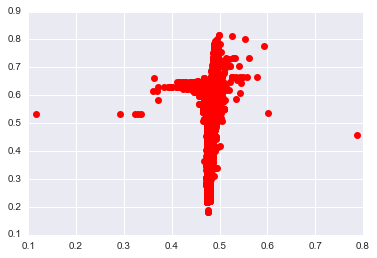

In [314]:
plt.plot(pred_logreg, predicted,'ro')

## Prev solution

In [35]:
X_prev = pd.read_csv("X_sparse.csv")

In [36]:
X_prev.head()

,customer_id,mcc_code_742,mcc_code_1711,mcc_code_1731,mcc_code_1799,mcc_code_2741,mcc_code_3000,mcc_code_3351,mcc_code_3501,mcc_code_4111,...,tr_type_7071,tr_type_7074,tr_type_7075,tr_type_8100,tr_type_8145,tr_type_8146,Mean_amount,Min_amount,Max_amount,Std_amount
0,6815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5528.561372,-224591.58,2470507.35,168370.985787
1,22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,0.0,0.0,-2691.438419,-868607.92,875907.15,127851.642622
2,27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-26820.061441,-462658.65,89836.63,104675.148673
3,28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-90293.479116,-3244539.76,3099363.77,785586.199773
4,31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5972.612548,-364366.15,199886.50,33418.557369


In [47]:
try_train = pd.concat([X_train.customer_id, X_train[X_train.columns[3:]]], axis=1)
try_val = pd.concat([X_train.customer_id, X_val[X_val.columns[3:]]], axis=1)

try_test = pd.concat([X_train.customer_id, test[test.columns[3:]]], axis=1)

In [48]:
try_train = pd.merge(try_train, X_prev).fillna(0)
try_val = pd.merge(try_val, X_prev).fillna(0)
try_test = pd.merge(try_test, X_prev).fillna(0)

In [49]:
try_train.head()

,customer_id,amount,k_type,k_mcc,k_mcc_traty,k_mcc_income,k_trtype_rashod,k_trtype_income,mcc_code_742,mcc_code_1711,...,tr_type_7071,tr_type_7074,tr_type_7075,tr_type_8100,tr_type_8145,tr_type_8146,Mean_amount,Min_amount,Max_amount,Std_amount
0,6815,-2770.465889,-0.160782,-0.157460,0.147842,0.349196,0.146184,0.821869,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5528.561372,-224591.58,2470507.35,168370.985787
1,6815,-5580.408182,-0.042922,-0.056353,0.049698,0.249510,0.084700,0.366052,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5528.561372,-224591.58,2470507.35,168370.985787
2,6815,-12464.835000,-0.042922,0.279057,0.057176,0.596813,0.084700,0.366052,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5528.561372,-224591.58,2470507.35,168370.985787
3,6815,-9703.427778,0.042832,-0.056353,0.049698,0.249510,0.092908,0.157318,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5528.561372,-224591.58,2470507.35,168370.985787
4,6815,47209.150000,-0.064336,-0.022971,0.212007,0.217838,0.000000,0.268630,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5528.561372,-224591.58,2470507.35,168370.985787


# Mean

In [49]:
mean_koef = dataset.groupby("customer_id")["k_type", "k_mcc", "k_mcc_traty", "k_mcc_income", "k_trtype_rashod", "k_trtype_income", "gender"].mean().reset_index()
mean_koef.columns = ["customer_id", "k_type_mean", "k_mcc_mean", "k_mcc_traty_mean", "k_mcc_income_mean", "k_trtype_rashod_mean", "k_trtype_income_mean", "gender"]

In [50]:
dataset1 = pd.merge(X_prev, mean_koef)

In [100]:
train_all = dataset1[pd.notnull(dataset1.gender)].set_index("customer_id")
test = dataset1[pd.isnull(dataset1.gender)].drop(["gender"], axis=1).set_index("customer_id")

In [101]:
for itr, ite in ShuffleSplit(train_all.shape[0], n_iter=4, train_size=0.7, test_size=0.3, random_state=0):
    pass

In [104]:
X_train = train_all.iloc[itr].drop(["gender"], axis=1)
X_val = train_all.iloc[ite].drop(["gender"], axis=1)


X_all = train_all.drop(["gender"], axis=1)
Y_all = train_all.gender

Y_train = train_all.gender.iloc[itr]
Y_val = train_all.gender.iloc[ite]

# Try with addit features

### sklearn gb

In [105]:
%%time
clf = GradientBoostingClassifier(max_depth=7, n_estimators=500, verbose=True, random_state=13)
clf.fit(X_train, Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2860            4.74m
         2           1.2134            4.70m
         3           1.1513            4.68m
         4           1.0965            4.72m
         5           1.0494            4.74m
         6           1.0056            4.72m
         7           0.9687            4.72m
         8           0.9362            4.73m
         9           0.9061            4.74m
        10           0.8785            4.75m
        20           0.7117            4.49m
        30           0.6264            4.34m
        40           0.5642            4.25m
        50           0.5181            4.01m
        60           0.4913            3.67m
        70           0.4708            3.37m
        80           0.4483            3.15m
        90           0.4258            3.02m
       100           0.4132            2.81m
       200           0.2734            1.78m
       300           0.1929            1.12m
       40

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=13, subsample=1.0, verbose=True,
              warm_start=False)

In [106]:
predicted_gb = clf.predict_proba(X_val)[:, 1]

In [107]:
auc_score = roc_auc_score(Y_val, predicted_gb)
print "Auc score %s" % str(auc_score) 

Auc score 0.870795003608


## xgboost

In [108]:
import xgboost as xgb

In [469]:
%%time
model = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=250, silent=True, \
                          objective='binary:logistic', nthread=-1, \
                          subsample=0.6, colsample_bytree=0.6, colsample_bylevel=0.7, seed=27)
model.fit(X_train, Y_train)

TypeError: a float is required

In [466]:
predicted = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(Y_val, predicted)
print "Auc score %s" % str(auc_score) 

Auc score 0.869231125742


xgb tuning

In [146]:
param = {}
param['max_depth'] = 3
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['eta'] = 0.01
param['subsample'] = 0.9
param['colsample_bytree'] = 0.7
param['colsample_bylevel'] = 0.8
param['min_child_weight'] = 8
param['gamma'] = 0.12
param['reg_alpha'] = 0.0001

numround = 2750

In [147]:
Xdatatrain = xgb.DMatrix(X_train, label = Y_train)
Xdataval = xgb.DMatrix(X_val, label = Y_val)

X_all_datatrain = xgb.DMatrix(X_all, label = Y_all)
Xdatatest = xgb.DMatrix(test)

plst = list(param.items())
watchlist = [(Xdatatrain, 'train'), (Xdataval, 'eval')]            

In [145]:
%%time
xgb.cv(param, X_all_datatrain, num_boost_round=5000, nfold=3, metrics="auc", \
       verbose_eval=10, as_pandas=False, seed=27)

[0]	train-auc:0.831906+0.00149301	test-auc:0.823575+0.000917958
[10]	train-auc:0.849264+0.00219297	test-auc:0.840046+0.000439467
[20]	train-auc:0.852664+0.00129109	test-auc:0.842749+0.00111827
[30]	train-auc:0.853621+0.00142253	test-auc:0.843201+0.000704273
[40]	train-auc:0.855035+0.000826473	test-auc:0.84462+0.00175901
[50]	train-auc:0.855889+0.00105975	test-auc:0.845574+0.0013103
[60]	train-auc:0.856899+0.00123808	test-auc:0.846585+0.00118462
[70]	train-auc:0.857651+0.00120321	test-auc:0.847339+0.000925273
[80]	train-auc:0.858369+0.00112212	test-auc:0.847962+0.000684645
[90]	train-auc:0.859041+0.00117558	test-auc:0.848603+0.000900583
[100]	train-auc:0.859629+0.00105149	test-auc:0.849278+0.00119181
[110]	train-auc:0.8603+0.000892655	test-auc:0.849826+0.00131332
[120]	train-auc:0.861009+0.000779084	test-auc:0.85046+0.00164291
[130]	train-auc:0.861829+0.000653861	test-auc:0.851171+0.00165758
[140]	train-auc:0.862638+0.00073684	test-auc:0.851787+0.00170661
[150]	train-auc:0.863302+0.0005

KeyboardInterrupt: 

Explore parameters

In [133]:
param_test1 = {
 'gamma':[i/100.0 for i in range(10,20,1)]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=3,
 min_child_weight=8, gamma=0.12, subsample=0.9, colsample_bytree=0.7, reg_alpha = 0.0001,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1, iid=False, cv=3, verbose=1000)

gsearch1.fit(X_all,Y_all)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Pickling array (shape=(271,), dtype=object).
Pickling array (shape=(12000,), dtype=int64).
Memmaping (shape=(271, 12000), dtype=float64) to new file /var/folders/cb/klp2b1n941s2d21364cg5kw40000gp/T/joblib_memmaping_pool_99459_4691881872/99459-4689144976-72676d8ab38e021e668f16da0008f696.pkl
[CV] gamma=0.1 .......................................................
Pickling array (shape=(271,), dtype=object).
Pickling array (shape=(12000,), dtype=float64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(7999,), dtype=int64).
Pickling array (shape=(4001,), dtype=int64).
Pickling array (shape=(271,), dtype=object).
Pickling array (shape=(12000,), dtype=int64).
Memmaping (shape=(271, 12000), dtype=float64) to old file /var/folders/cb/klp2b1n941s2d21364cg5kw40000gp/T/joblib_memmaping_pool_99459_4691881872/99459-4689144976-72676d8ab38e021e668f16da0008f696.pkl
Pickling array (shape=(271,), dtype=object).
Pickling arr

([mean: 0.87778, std: 0.00085, params: {'gamma': 0.1},
  mean: 0.87778, std: 0.00085, params: {'gamma': 0.11},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.12},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.13},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.14},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.15},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.16},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.17},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.18},
  mean: 0.87789, std: 0.00098, params: {'gamma': 0.19}],
 {'gamma': 0.12},
 0.87789080388983887)

In [148]:
%%time
bst = xgb.train(plst, X_all_datatrain, numround, verbose_eval = 10)

CPU times: user 2min 35s, sys: 2.46 s, total: 2min 38s
Wall time: 2min 50s


In [283]:
y_pred_xgb = bst.predict(Xdatatest)

In [285]:
res_xgb

array([ 0.96155071,  0.06284573,  0.85026026, ...,  0.27014682,
        0.03086308,  0.51600796], dtype=float32)

In [286]:
res_xgb = y_pred_xgb
result = pd.DataFrame(test.index, columns=['customer_id'])
result['gender'] = res_xgb

In [287]:
result.head()

,customer_id,gender
0,49101,0.431638
1,114348,0.754771
2,127946,0.727174
3,137367,0.718330
4,174467,0.705088


In [69]:
result.to_csv('TASK1_xgb_addit.csv', index=False)

In [258]:
best_xgb = pd.read_csv('TASK1_xgb_addit.csv').gender.values

## logreg

In [155]:
from sklearn.linear_model import LogisticRegression

In [224]:
logreg = LogisticRegression(max_iter=500, n_jobs=-1, C=3.8)
logreg.fit(X_train, Y_train)

LogisticRegression(C=3.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [227]:
y_pred_logreg = logreg.predict_proba(X_val)[:, 1]
#y_pred_logreg = map(lambda x: x[1], pred_logreg)
print "Auc score %s" % str(roc_auc_score(Y_val, y_pred_logreg)) 

Auc score 0.748968792589


In [248]:
len(y_pred_logreg)

3600

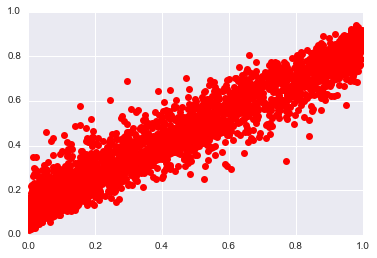

In [270]:
plt.plot(res_xgb, y_pred_rf, 'ro')

In [261]:
best_logreg = pd.read_csv('baseline_logreg.csv').gender.values

In [262]:
best_logreg

array([ 0.46449952,  0.86801099,  0.52515357, ...,  0.38524009,
        1.        ,  0.02958033])

## rf

In [237]:
from sklearn.ensemble import RandomForestClassifier

In [249]:
%%time
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [250]:
y_pred_rf = rf.predict_proba(X_val)[:,1]
print "Auc score %s" % str(roc_auc_score(Y_val, y_pred_rf)) 

Auc score 0.866634944434


In [251]:
rf.fit(X_all, Y_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [253]:
y_pred_rf = rf.predict_proba(test)[:,1]

In [254]:
res_rf = y_pred_rf
result = pd.DataFrame(test.index, columns=['customer_id'])
result['gender'] = res_rf

In [255]:
result.head()

,customer_id,gender
0,49101,0.401864
1,114348,0.723001
2,127946,0.688512
3,137367,0.659194
4,174467,0.678691


## Try composition

In [288]:
koef_xgb = 0.8
koef_rf = 0.1
y_pred_comp = koef_xgb*res_xgb + koef_rf*y_pred_rf + (1-koef_xgb-koef_rf)*best_logreg

In [289]:
result = pd.DataFrame(test.index, columns=['customer_id'])
result['gender'] = y_pred_comp

In [290]:
result.head()

,customer_id,gender
0,49101,0.431947
1,114348,0.762918
2,127946,0.703106
3,137367,0.681379
4,174467,0.682187


In [291]:
result.to_csv('TASK1_xgb08_rf01_logreg_addit.csv', index=False)